In [40]:
#!pip install syntheval

In [41]:
import pandas as pd
import numpy as np

In [42]:
# Go to the /users/pgrad/mamu/Documents/first/ directory 
import os
os.chdir('/users/pgrad/mamu/Documents/first')

In [43]:
# Load datasets
original_data = pd.read_csv('./datasets/data.csv')
generated_data = pd.read_csv('./llama3-8b/results/synthetic_data_llama_3_8b.csv')

# Subset the datasets to the minimum length
min_len = min(len(original_data), len(generated_data))
original_data = original_data.iloc[:min_len]
generated_data = generated_data.iloc[:min_len]


In [44]:
# import the categories dictionary from json
import json

with open('./evaluation/tools/categories.json') as f:
    categories = json.load(f)

# Initialize the category counts
categories_count = {
    "Respiratory Diseases": 0,
    "Skin Diseases": 0,
    "Endocrine and Metabolic Diseases": 0,
    "Mental and Behavioral Disorders": 0,
    "Cardiovascular Diseases": 0,
    "Gastrointestinal Diseases": 0,
    "Cancers": 0,
    "Neurological Disorders": 0,
    "Musculoskeletal Diseases": 0,
    "Infectious Diseases": 0,
    "Urinary and Reproductive Diseases": 0,
    "Blood Disorders": 0,
    "Genetic Disorders": 0,
    "Miscellaneous": 0
}

# Function to classify diseases into categories and update counts
def classify_disease(disease):
    for category, diseases in categories.items():
        if disease in diseases:
            categories_count[category] += 1
            return category
    return 'Miscellaneous'

In [45]:
original_data['Disease Category'] = original_data['Disease'].apply(classify_disease)
generated_data['Disease Category'] = generated_data['Disease'].apply(classify_disease)

# One hot encode the disease categories
original_data = pd.concat([original_data, pd.get_dummies(original_data['Disease Category'])], axis=1)
generated_data = pd.concat([generated_data, pd.get_dummies(generated_data['Disease Category'])], axis=1)

In [46]:
original_data

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable,...,Gastrointestinal Diseases,Genetic Disorders,Infectious Diseases,Mental and Behavioral Disorders,Miscellaneous,Musculoskeletal Diseases,Neurological Disorders,Respiratory Diseases,Skin Diseases,Urinary and Reproductive Diseases
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive,...,0,0,0,0,0,0,0,1,0,0
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative,...,0,0,0,0,0,0,0,1,0,0
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative,...,0,0,0,0,0,0,0,0,1,0
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,...,0,0,0,0,0,0,0,1,0,0
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,...,0,0,0,0,0,0,0,0,0,0
344,Stroke,Yes,No,Yes,No,80,Female,High,High,Positive,...,0,0,0,0,0,0,0,0,0,0
345,Stroke,Yes,No,Yes,No,85,Male,High,High,Positive,...,0,0,0,0,0,0,0,0,0,0
346,Stroke,Yes,No,Yes,No,85,Male,High,High,Positive,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# print column names
print(original_data.columns)

Index(['Disease', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Age',
       'Gender', 'Blood Pressure', 'Cholesterol Level', 'Outcome Variable',
       'Disease Category', 'Blood Disorders', 'Cancers',
       'Cardiovascular Diseases', 'Endocrine and Metabolic Diseases',
       'Gastrointestinal Diseases', 'Genetic Disorders', 'Infectious Diseases',
       'Mental and Behavioral Disorders', 'Miscellaneous',
       'Musculoskeletal Diseases', 'Neurological Disorders',
       'Respiratory Diseases', 'Skin Diseases',
       'Urinary and Reproductive Diseases'],
      dtype='object')


In [48]:

print(original_data.shape)
print(generated_data.shape)

(348, 25)
(348, 25)


In [49]:
# Fill missing values with 0 for numerical columns
original_data = original_data.fillna(0)
generated_data = generated_data.fillna(0)

# Ensure all columns expected to be numerical are converted to numerical data types
numerical_columns = original_data.select_dtypes(include=['float64', 'int64']).columns

original_data[numerical_columns] = original_data[numerical_columns].apply(pd.to_numeric)
generated_data[numerical_columns] = generated_data[numerical_columns].apply(pd.to_numeric)

# Verify data types again
data_types_original = original_data.dtypes
data_types_generated = generated_data.dtypes

original_data.drop(columns=['Disease'], inplace=True)
generated_data.drop(columns=['Disease'], inplace=True)

data_types_original, data_types_generated

(Disease                              object
 Fever                                object
 Cough                                object
 Fatigue                              object
 Difficulty Breathing                 object
 Age                                   int64
 Gender                               object
 Blood Pressure                       object
 Cholesterol Level                    object
 Outcome Variable                     object
 Disease Category                     object
 Blood Disorders                       uint8
 Cancers                               uint8
 Cardiovascular Diseases               uint8
 Endocrine and Metabolic Diseases      uint8
 Gastrointestinal Diseases             uint8
 Genetic Disorders                     uint8
 Infectious Diseases                   uint8
 Mental and Behavioral Disorders       uint8
 Miscellaneous                         uint8
 Musculoskeletal Diseases              uint8
 Neurological Disorders                uint8
 Respirato

In [50]:
features = ['Blood Disorders', 'Cancers',
       'Cardiovascular Diseases', 'Endocrine and Metabolic Diseases',
       'Gastrointestinal Diseases', 'Genetic Disorders', 'Infectious Diseases',
       'Mental and Behavioral Disorders', 'Miscellaneous',
       'Musculoskeletal Diseases', 'Neurological Disorders',
       'Respiratory Diseases', 'Skin Diseases',
       'Urinary and Reproductive Diseases']

SynthEval: inferred categorical columns...
SynthEval: synthetic data read successfully


Syntheval: dwm:   0%|          | 0/17 [00:00<?, ?it/s]

Syntheval: ks_test:  29%|██▉       | 5/17 [00:03<00:10,  1.11it/s]  /users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/syntheval/metrics/utility/metric_kolmogorov_smirnov.py:79: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  KstestResult = ks_2samp(R,F)
Syntheval: h_dist:  35%|███▌      | 6/17 [00:04<00:09,  1.11it/s] /users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/syntheval/metrics/utility/metric_hellinger_distance.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  bin_width = np.ceil(n**(1/3) * std / (3.5 * (np.percentile(samples, 75) - np.percentile(samples, 25)))).astype(int)
Syntheval: nndr:  35%|███▌      | 6/17 [00:04<00:09,  1.11it/s]  /users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/syntheval/metrics/privacy/metric_nn_distance_ratio.py:39: RuntimeWarning: invalid value encountered in float_scalars
  dr = list(map(lambda x: x[0] / x[1], np.transpose(dist)))
Synt

Error: AUROC metric did not run, analysis target variable did not have appropriate number levels (i.e. 2) or test data was not supplied!


/users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' wa

Error: Membership inference attack metric did not run, holdout data was not supplied!


Syntheval: att_discl: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


SynthEval results

Utility metric description                    value   error                                 
+---------------------------------------------------------------+
| Average dimensionwise means diff. (nums) :   0.0381  0.0048   |
| PCA difference in eigenvalues (exp. var.):   0.0142           |
| PCA angle between eigenvectors (radians) :   0.6236           |
| Average confidence interval overlap      :   0.1512  0.0827   |
|   -> # non-overlapping COIs at 95%       :   11               |
|   -> fraction of non-overlapping CIs     :   0.7333           |
| Mixed correlation matrix difference      :   0.8789           |
| Pairwise mutual information difference   :   0.6163           |
| Kolmogorov–Smirnov / Total Variation Distance test            |
|   -> average combined statistic          :   0.0609  0.0162   |
|       -> avg. Kolmogorov–Smirnov dist.   :   0.0538  0.0224   |
|       -> avg. Total Variation Distance   :   0.0728  0.0227   |
|   -> average combined p-val

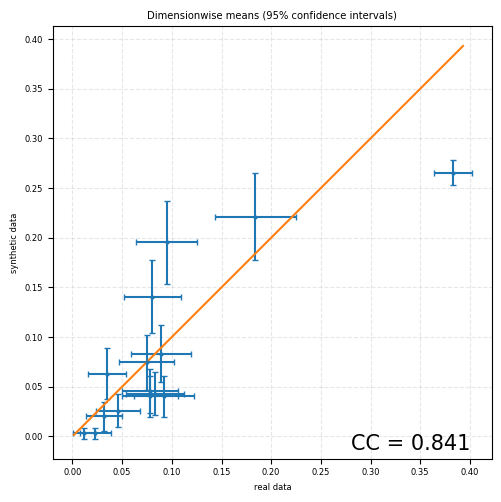

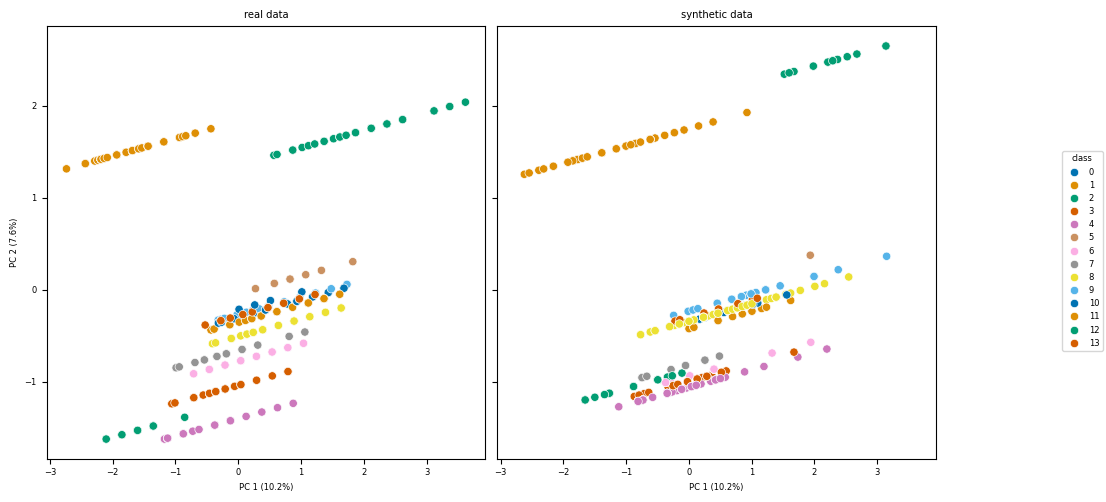

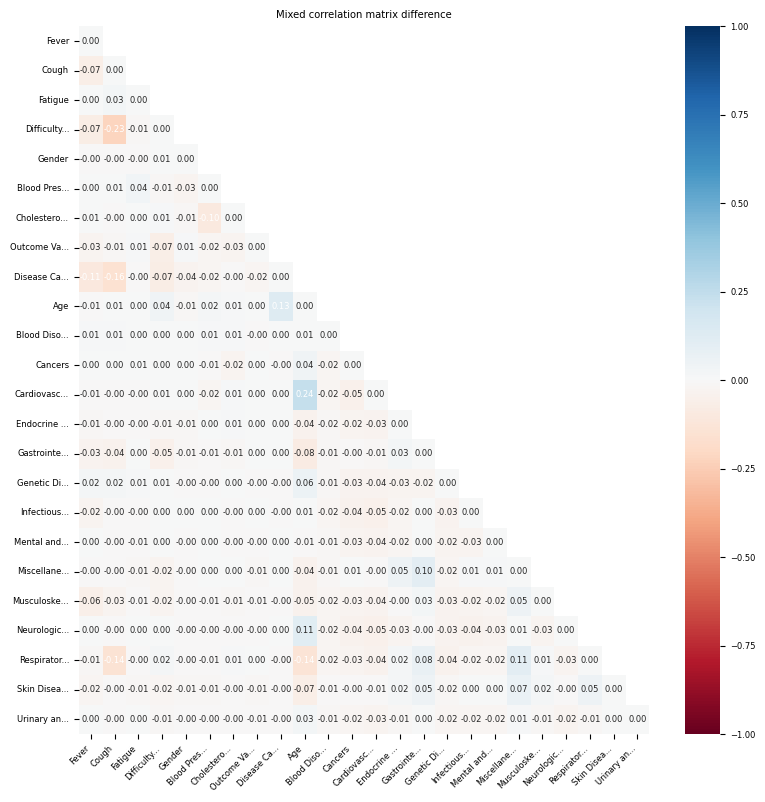

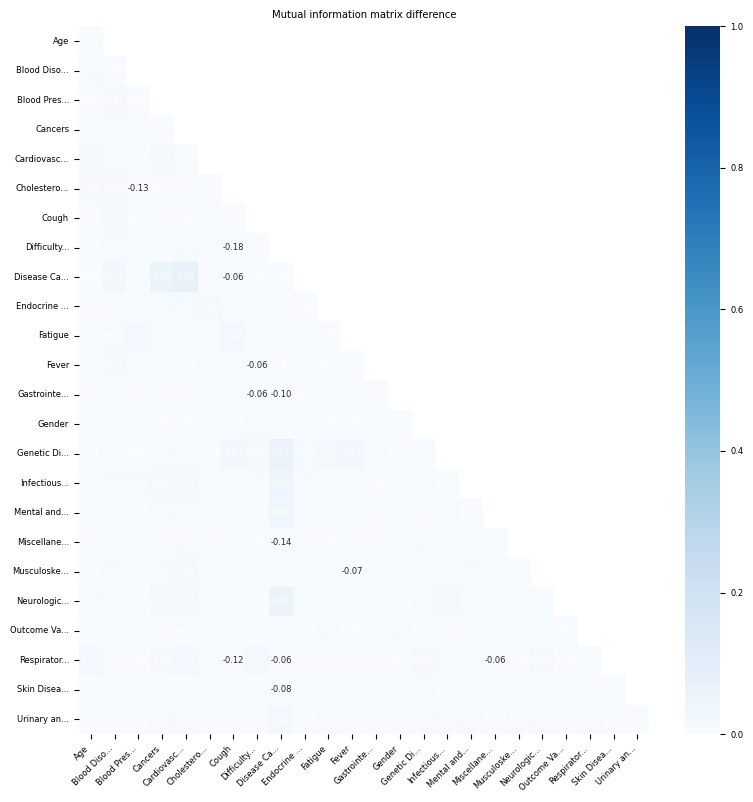

In [51]:
from syntheval import SynthEval

evaluator = SynthEval(original_data)
_ = evaluator.evaluate(generated_data, 'Disease Category', "full_eval")